In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from PIL import Image
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
%matplotlib inline

Using TensorFlow backend.
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Future

In [2]:
#Import data train dan data test
data_train = pd.read_csv('data_train_fix.csv')
data_test = pd.read_csv('data_test_fix.csv')
data_train = data_train.sample(frac=1) #Acak data

In [3]:
#Menentukan ukuran citra dan input_shape
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 1)

In [4]:
#Data train
X_train = np.array(data_train.iloc[:, 1:])
y_train = to_categorical(np.array(data_train.iloc[:, 0]))

In [5]:
data_train.tail()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024
122,3,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
752,18,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
933,23,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
234,5,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
747,18,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [6]:
#Data test
y_test_label = data_test[['label']]
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

In [7]:
X_train.shape

(1040, 1024)

In [8]:
#Praproses data sebelum di train
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [9]:
X_train.shape

(1040, 32, 32, 1)

In [28]:
#Menentukan jumlah kelas dan hyperparameter
num_classes = 26
adam = Adam(lr=0.001)
epochs=20
batch_size=50
# IMAGE_SIZE = (32,32,1)

In [29]:
#Proses pembuatan model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu', padding='same',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 5, 128)         73856     
__________

In [34]:
#Proses pelatihan model dengan metode K-Fold Cross Validation
from sklearn.model_selection import KFold
pat = 1 
k_folds=10
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
model_checkpoint = ModelCheckpoint('foldmodel.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

kf = KFold(k_folds,random_state=42)
model_history = [] 
i = 0
start = time.time()
for train_index, test_index in kf.split(X_train):
    
    print("Training on Fold ", i+1)
    X_tr, X_val = X_train[train_index], X_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    
    model_history.append(model.fit(X_tr, y_tr,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  callbacks=[early_stopping, model_checkpoint],
                                  verbose=1, validation_data=(X_val, y_val)))
    i+=1
    
end = time.time()
durasi = end-start

Training on Fold  1
Train on 936 samples, validate on 104 samples
Epoch 1/20
100/936 [==>...........................] - ETA: 1s - loss: 0.0460 - acc: 0.9900

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


936/936 [==============================] - 1s 1ms/step - loss: 0.0597 - acc: 0.9733 - val_loss: 0.0308 - val_acc: 0.9808

Epoch 00001: val_loss improved from inf to 0.03083, saving model to foldmodel13.h5
Epoch 2/20
936/936 [==============================] - 1s 1ms/step - loss: 0.0512 - acc: 0.9776 - val_loss: 0.0290 - val_acc: 0.9904

Epoch 00002: val_loss improved from 0.03083 to 0.02896, saving model to foldmodel13.h5
Epoch 3/20
936/936 [==============================] - 1s 1ms/step - loss: 0.0663 - acc: 0.9701 - val_loss: 0.0254 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.02896 to 0.02536, saving model to foldmodel13.h5
Epoch 4/20
936/936 [==============================] - 1s 1ms/step - loss: 0.0461 - acc: 0.9882 - val_loss: 0.0275 - val_acc: 0.9904

Epoch 00004: val_loss did not improve from 0.02536
Epoch 00004: early stopping
Training on Fold  2
Train on 936 samples, validate on 104 samples
Epoch 1/20
936/936 [==============================] - 1s 1ms/step - loss: 0.0

In [35]:
#Evaluasi model terhadap data test
score = model.evaluate(X_test, y_test)

260/260 [==============================] - 0s 348us/step


In [36]:
#Menghitung waktu pelatihan model
if durasi<60:
    print("Waktu:",durasi,"detik")
else: 
    durasi = durasi/60
    print("Waktu:",durasi,"menit")

Waktu: 30.8068950176239 detik


In [ ]:
# model.save('foldmodel12.h5')
# model.save_weights('foldmodelweights12.h5')

# -----------------------BATAS------------------------------BATAS-----------------

In [23]:
acc = []
loss = []
val_acc = []
val_loss = []
for i in range(0,10):
    x = model_history[i].history['val_acc']
    x = np.max(x)
    val_acc.append(x)
        
for i in range(0,10):
    x = model_history[i].history['acc']
    x = np.max(x)
    acc.append(x)
        
for i in range(0,10):
    x = model_history[i].history['loss']
    x = np.min(x)
    loss.append(x)
        
for i in range(0,10):
    x = model_history[i].history['val_loss']
    x = np.min(x)
    val_loss.append(x)
    
# print(acc)
# print(loss)
# print(val_acc)
print(val_loss)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[0.34577827327526534, 0.053989954077853605, 0.07098105506828198, 0.03489536441002901, 0.03145686203900438, 0.01603056672656049, 0.03184388965522745, 0.004867129294815151, 0.04081745338268005, 0.038003983441740274]
Test loss: 0.025923369624293768
Test accuracy: 0.9884615384615385


In [24]:
print(np.max(model_history[7].history['acc']))
print(np.min(model_history[7].history['loss']))
print(np.max(model_history[7].history['val_acc']))
print(np.min(model_history[7].history['val_loss']))
print(np.max(model_history[8].history['acc']))
print(np.min(model_history[8].history['loss']))
print(np.max(model_history[8].history['val_acc']))
print(np.min(model_history[8].history['val_loss']))
print(np.max(model_history[9].history['acc']))
print(np.min(model_history[9].history['loss']))
print(np.max(model_history[9].history['val_acc']))
print(np.min(model_history[9].history['val_loss']))

0.967948718330799
0.08082386156002808
1.0
0.004867129294815151
0.9690170982199856
0.0868595396566531
0.9903846245545608
0.04081745338268005
0.9711538498472964
0.08547582980404553
0.9711538450076029
0.038003983441740274


In [21]:
#Melihat nilai akurasi, loss, val akurasi dan val loss setiap fold dari histori model
acc = []
loss = []
val_acc = []
val_loss = []

for i in range(0,10):
    x = model_history[i].history['acc']
    acc.append(x)
    
for i in range(0,10):
    x = model_history[i].history['loss']
    loss.append(x)
    
for i in range(0,10):
    x = model_history[i].history['val_acc']
    val_acc.append(x)
    
for i in range(0,10):
    x = model_history[i].history['val_loss']
    val_loss.append(x)
    
# print(np.max(acc))
# print(np.min(loss))
# print(np.max(val_acc))
print(np.min(val_loss))
print(val_loss)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[0.004867129294815151, 0.005971593306849872]
[[3.233926924375387, 3.0401253012510447, 2.266696952856504, 1.6153097336108868, 1.0523383181828718, 0.7970849653849235, 0.5795618788554118, 0.5086099493962067, 0.4679091601417615, 0.40101513266563416, 0.3746204221477875, 0.34577827327526534, 0.37692563293071896], [0.053989954077853605, 0.05881140775118883], [0.08348655679191534, 0.07276096374083024, 0.07098105506828198, 0.08478751828750739], [0.03489536441002901, 0.07071131510803333], [0.050186976933708556, 0.03145686203900438, 0.04424814643481603], [0.01603056672656049, 0.030466330824240755], [0.0338288978404867, 0.03235956544701297, 0.032282296406964846, 0.03184388965522745, 0.04084000438272666], [0.004867129294815151, 0.005971593306849872], [0.04081745338268005, 0.04311739961401774], [0.038132403441033184, 0.038003983441740274, 0.04021111460259327]]
Test loss: 0.025923369624293768
Test accuracy: 0.9884615384615385


In [385]:
print(model_history[0].history['acc'])
print(model_history[0].history['loss'])
print(model_history[0].history['val_acc'])
print(model_history[0].history['val_loss'])

[0.04594017008048856, 0.041666665902504556, 0.06623931538759388, 0.12820512794244748, 0.2361111107449501, 0.4049145311881334, 0.5651709416355842, 0.6314102581933013, 0.7200854677929838, 0.7724358936150869, 0.8119658085270824, 0.8279914484064803]
[3.3631894868663235, 3.2536434938764978, 3.228353105039678, 3.04923102641717, 2.551126330326765, 1.9429062431694095, 1.4217910291547449, 1.1408880662459593, 0.8525225115128052, 0.6942078664771512, 0.5800547359081415, 0.5652355779057894]
[0.01923076880092804, 0.11538461817858311, 0.1346153887705161, 0.3461538404226303, 0.4711538398495087, 0.6634615545089428, 0.7211538450076029, 0.7788461458224517, 0.8461538404226303, 0.8653846107996427, 0.8749999954150274, 0.8846153708604666]
[3.262376455160288, 3.2328166915820193, 3.1766459345817566, 2.7724592181352468, 2.016541552085143, 1.3988829025855432, 0.9984017553237768, 0.8313982268938651, 0.5918403944143882, 0.5212902409526018, 0.4392138152168347, 0.45721199134221446]


In [384]:
print(np.max(model_history[7].history['acc']))
print(np.min(model_history[7].history['loss']))
print(np.max(model_history[7].history['val_acc']))
print(np.min(model_history[7].history['val_loss']))
print(np.max(model_history[8].history['acc']))
print(np.min(model_history[8].history['loss']))
print(np.max(model_history[8].history['val_acc']))
print(np.min(model_history[8].history['val_loss']))
print(np.max(model_history[9].history['acc']))
print(np.min(model_history[9].history['loss']))
print(np.max(model_history[9].history['val_acc']))
print(np.min(model_history[9].history['val_loss']))

0.9626068414276482
0.09656984047789095
1.0
0.017067654792649243
0.9679487199864836
0.07725596917458834
1.0
0.017613587157729153
0.9711538481916118
0.07922039516906962
0.9807692491091214
0.04591087733458083


Execution Time: 57.579904079437256 seconds


In [61]:
acc = []
loss = []
val_acc = []
val_loss = []
for i in range(0,10):
    x = model_history[i].history['val_acc']
    x = np.max(x)
    val_acc.append(x)
        
for i in range(0,10):
    x = model_history[i].history['acc']
    x = np.max(x)
    acc.append(x)
        
for i in range(0,10):
    x = model_history[i].history['loss']
    x = np.min(x)
    loss.append(x)
        
for i in range(0,10):
    x = model_history[i].history['val_loss']
    x = np.min(x)
    val_loss.append(x)

In [62]:
acc

[0.8547008575027825,
 0.8963675149995037,
 0.9423076861943954,
 0.9294871690436306,
 0.9444444362933819,
 0.9679487133637453,
 0.9561965733002393,
 0.9679487128543038,
 0.9604700791020678,
 0.9679487131090245]

In [63]:
loss

[0.4855437205833757,
 0.3143409821722243,
 0.16667415666529256,
 0.18888099245631543,
 0.15455823513066286,
 0.09000795651087935,
 0.1050406180602761,
 0.09991742256415896,
 0.11962106034884022,
 0.10633824645286888]

In [64]:
val_acc

[0.8846153914928436,
 0.9807692261842581,
 0.9711538392763871,
 0.9711538392763871,
 0.990384613092129,
 1.0,
 0.990384613092129,
 1.0,
 1.0,
 1.0]

In [65]:
val_loss

[0.5535176465144525,
 0.09688820181271204,
 0.08702022947657567,
 0.0817825619596988,
 0.025359099850063033,
 0.013590377227116663,
 0.034000769825070165,
 0.0031956921201736596,
 0.01721936967470146,
 0.028783317686667524]

In [104]:
acc

[0.9700854644816146,
 0.9807692264389788,
 0.9786324735380646,
 0.974358969519281,
 0.9732905919225807,
 0.9882478604459355,
 0.9818376025073549,
 0.9711538405499907,
 0.9850427314766452,
 0.9797008511347648]

In [99]:
print(np.max(acc))
print(np.min(loss))
print(np.max(val_acc))
print(np.min(val_loss))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

0.9882478604459355
0.04122231599852905
1.0
0.0013098794174416421
Test loss: 0.028166965952536534
Test accuracy: 0.9884615384615385


In [82]:
# I read first as training loss much greater than validation loss. That is underfitting.

# I read second as training loss much less than validation loss. That is overfitting.

In [110]:
# plt.title('Accuracies vs Epochs')
# plt.plot(model_history[0].history['acc'], label='Training Fold 1')
# plt.plot(model_history[1].history['acc'], label='Training Fold 2')
# plt.plot(model_history[2].history['acc'], label='Training Fold 3')
# plt.plot(model_history[3].history['acc'], label='Training Fold 4')
# plt.plot(model_history[4].history['acc'], label='Training Fold 5')
# plt.plot(model_history[5].history['acc'], label='Training Fold 6')
# plt.plot(model_history[6].history['acc'], label='Training Fold 7')
# plt.plot(model_history[7].history['acc'], label='Training Fold 8')
# plt.plot(model_history[8].history['acc'], label='Training Fold 9')
# plt.plot(model_history[9].history['acc'], label='Training Fold 10')

# # plt.plot(model_history[3].history['acc'], label='Training Fold 4')
# # plt.plot(model_history[4].history['acc'], label='Training Fold 5')
# # plt.plot(model_history[5].history['acc'], label='Training Fold 6')
# # plt.plot(model_history[6].history['acc'], label='Training Fold 7')
# # plt.plot(model_history[7].history['acc'], label='Training Fold 8')
# # plt.plot(model_history[8].history['acc'], label='Training Fold 9')
# # plt.plot(model_history[9].history['acc'], label='Training Fold 10')
# plt.legend()
# plt.show()


In [112]:
# plt.title('Train Accuracy vs Val Accuracy')
# plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
# plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
# plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='red', )
# plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
# plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='green', )
# plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
# plt.legend()
# plt.show()

In [48]:
from keras.models import load_model
model = load_model('foldmodel2.h5')

In [49]:
model.evaluate(X_test, y_test)

260/260 [==============================] - 0s 2ms/step


[0.028288657186098694, 0.9884615384615385]

In [50]:
#function for converting predictions to labels
def prep_submissions(preds_array, file_name='abc.csv'):
    preds_df = pd.DataFrame(preds_array)
    predicted_labels = preds_df.idxmax(axis=1) #convert back one hot encoding to categorical variabless
    return predicted_labels

In [51]:
test_preds = model.predict(X_test)
test_preds_labels = prep_submissions(test_preds)
test_preds_labels

0       0
1       0
2       0
3       0
4       0
       ..
255    25
256    25
257    25
258    25
259    25
Length: 260, dtype: int64

In [28]:
print(classification_report(y_test_label, test_preds_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      0.70      0.82        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       0.77      1.00      0.87        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

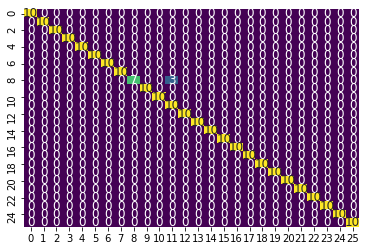

In [22]:
draw_confusion_matrix(y_test_label, test_preds_labels)

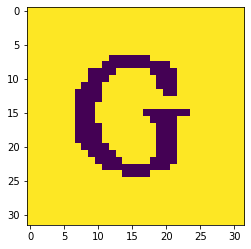

In [168]:
test_im = X_train[230]
plt.imshow(test_im.reshape(32,32), cmap='viridis', interpolation='none')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


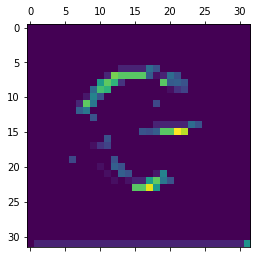

In [169]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,32,32,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


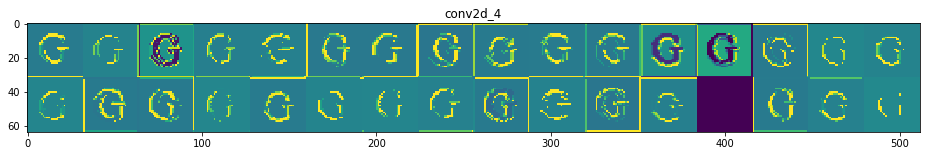

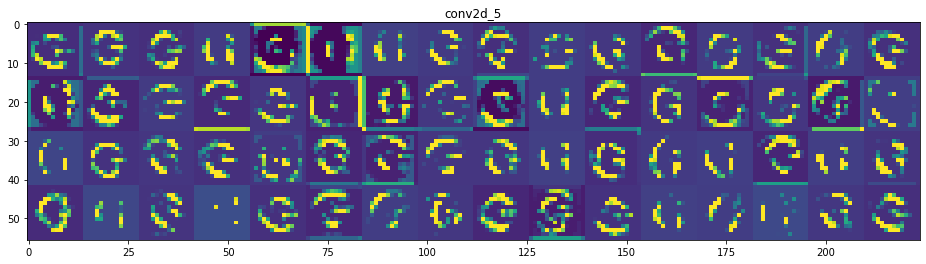

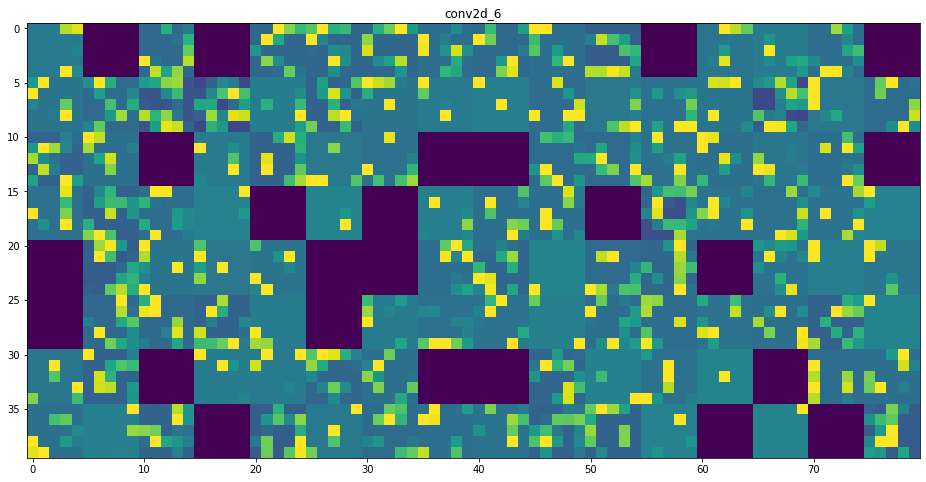

In [170]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
# #Train the model with K-fold Cross Val
# n_folds=10
# epochs=20
# batch_size=128
# from sklearn.model_selection import KFold

# #save the model history in a list after fitting so that we can plot later
# model_history = [] 

# for i in range(n_folds):
#     print("Training on Fold: ",i+1)
#     t_x, val_x, t_y, val_y = train_test_split(train_x, train_y, test_size=0.1, 
#                                                random_state = np.random.randint(1,1000, 1)[0])
#     model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
#     print("======="*12, end="\n\n\n")

In [ ]:
# X_train = data_train.iloc[:, 1:]
# X_train = X_train.values
# X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
# X_train = X_train/255
# X_train
# ### read the image labels and one hot encode the labels
# # y_train_label = data_train[['label']]
# #do one hot encoding with the earlier created function
# y_train = one_hot_encoder(y_train_label, 'label', 'lab')

# #get the labels as an array
# y_train = y_train.values

# y_train

# X_train
# y_train
# test_x_scaled
# test_images_y_encoded

# #check to see if distribution of target labels are equal (if not equal we need to assign weights to classes)
# plt.bar(y_train_label['label'].value_counts().index, y_train_label['label'].value_counts().values)

# X_test = data_test.iloc[:,1:]

# X_test = X_test.values
# X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
# X_test = X_test/255

# #Read test dataset labels
# y_test_label = data_test[['label']]
# y_test = one_hot_encoder(y_test_label, 'label', 'lab')
# #get the labels as an array
# y_test = y_test.values

In [ ]:
#one hot encoding function
def one_hot_encoder(df_name, df_column_name, suffix=''):
    temp = pd.get_dummies(df_name[df_column_name]) #get dummies is used to create dummy columns
    df_name = df_name.join(temp, lsuffix=suffix) #join the newly created dummy columns to original dataframe
    df_name = df_name.drop(df_column_name, axis=1) #drop the old column used to create dummy columnss
    return df_name

#function to draw confusion matrix
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()
    #return conf_matx
    
draw_confusion_matrix(y_test_label, test_preds_labels)